In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
class FFN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN):
        super().__init__()
        activation = nn.Tanh
        self.ffni = nn.Sequential(nn.Linear(N_INPUT, N_HIDDEN), activation())
        self.ffnh = nn.Sequential(nn.Linear(N_HIDDEN, N_HIDDEN), activation())
        self.ffne = nn.Sequential(nn.Linear(N_HIDDEN, N_OUTPUT))

    def forward(self, x):
        x = self.ffni(x)
        x = self.ffnh(x)
        x = self.ffnh(x)
        x = self.ffne(x)
        return x

In [3]:
pinn = FFN(1,1,8)

In [4]:
optimiser = torch.optim.Adam(pinn.parameters(), lr=1e-3)

In [5]:
T_physics = ?

SyntaxError: invalid syntax (<ipython-input-5-4ac3ef635c4f>, line 1)

Epoch 0, Loss: 10079.281250


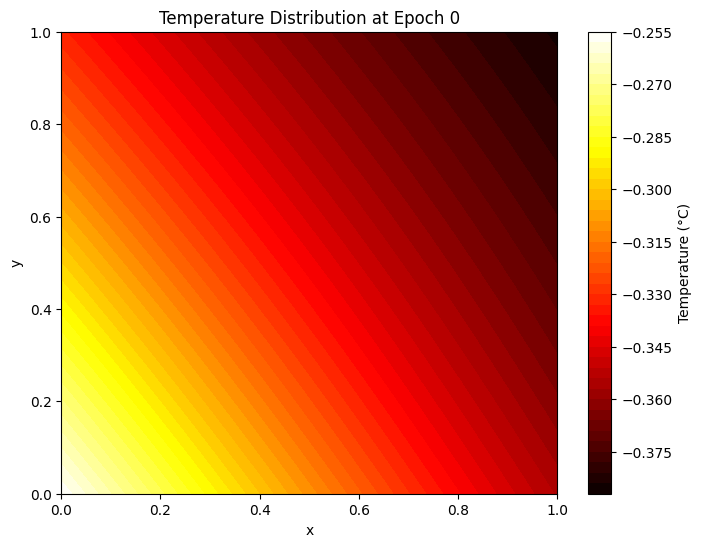

Epoch 500, Loss: 8113.927246


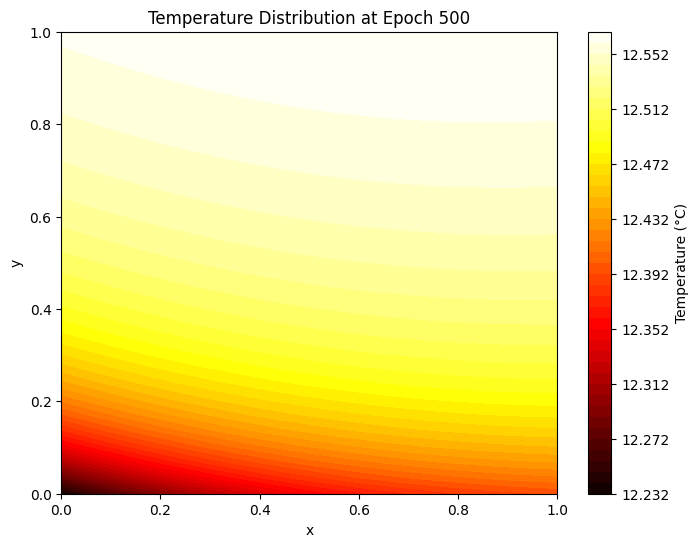

Epoch 1000, Loss: 6487.018555


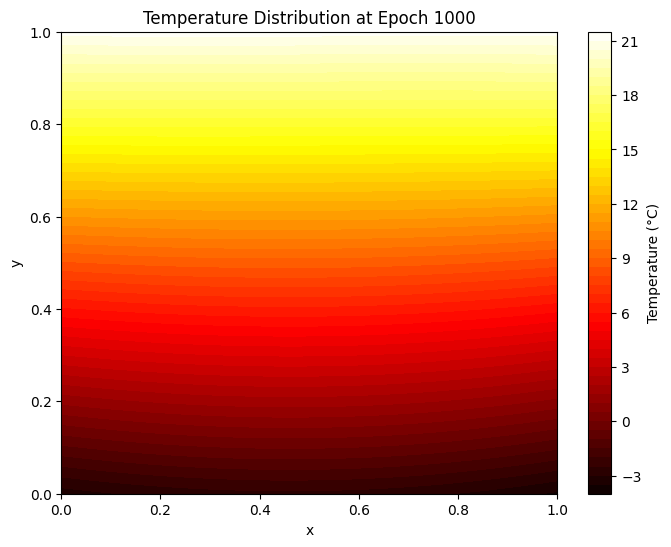

Epoch 1500, Loss: 5294.331543


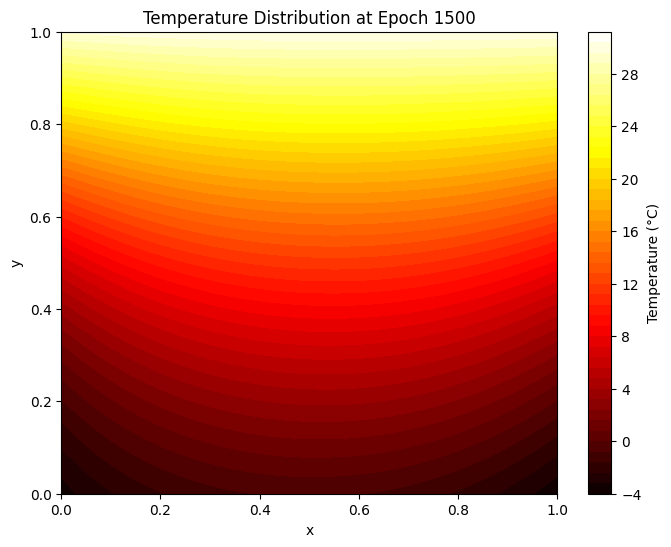

Epoch 2000, Loss: 4550.622559


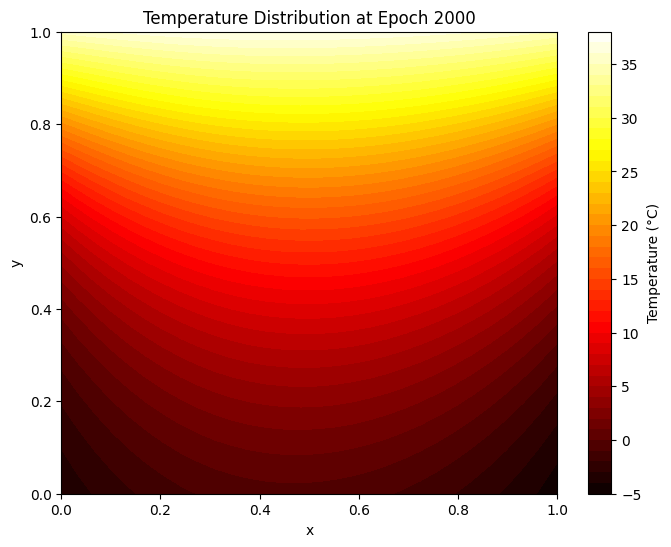

Epoch 2500, Loss: 3601.525879


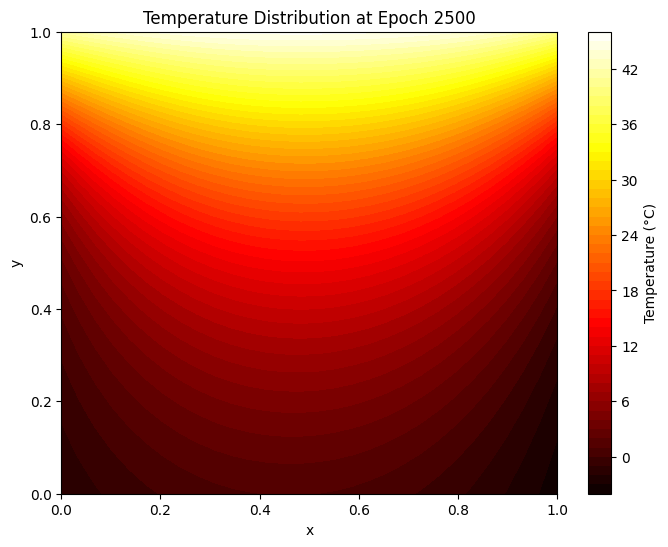

Epoch 3000, Loss: 2942.345215


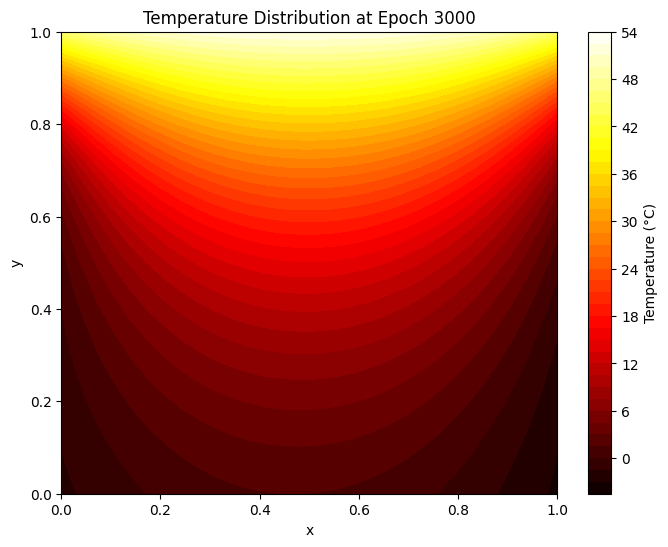

Epoch 3500, Loss: 2364.670654


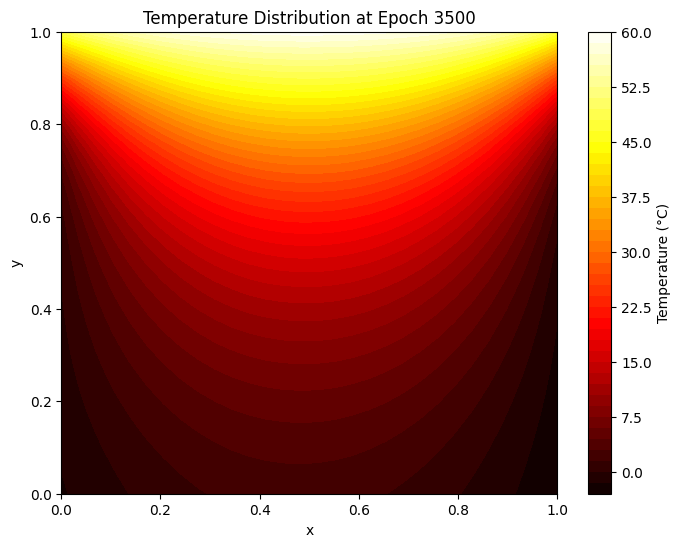

Epoch 4000, Loss: 1942.431519


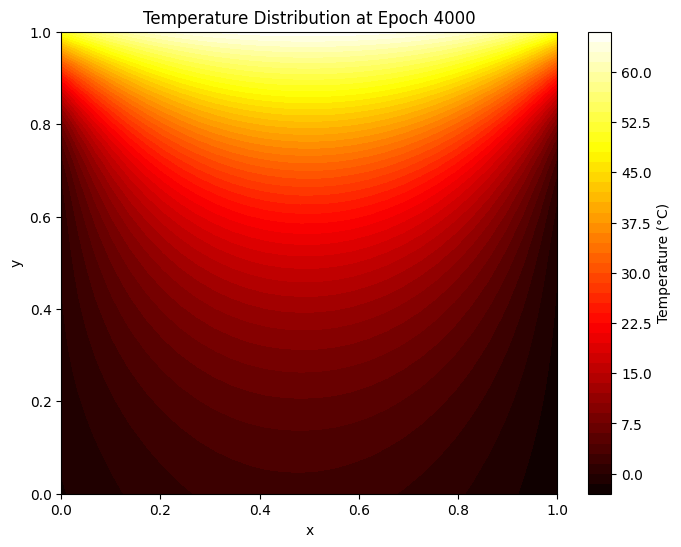

Epoch 4500, Loss: 1596.958740


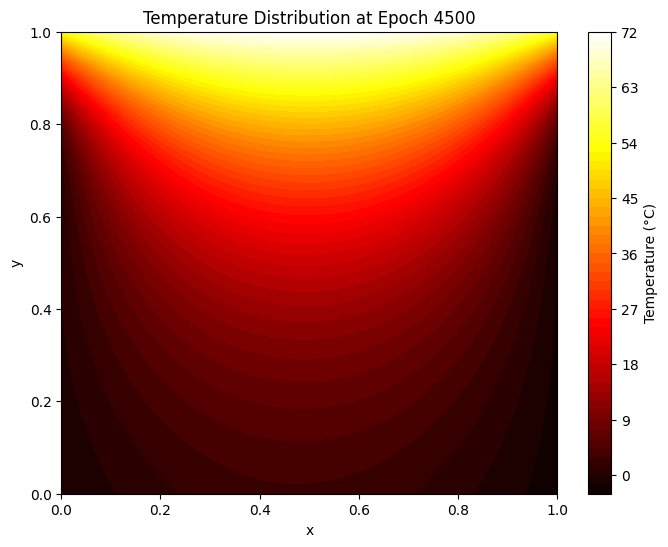

Epoch 4999, Loss: 1287.865723


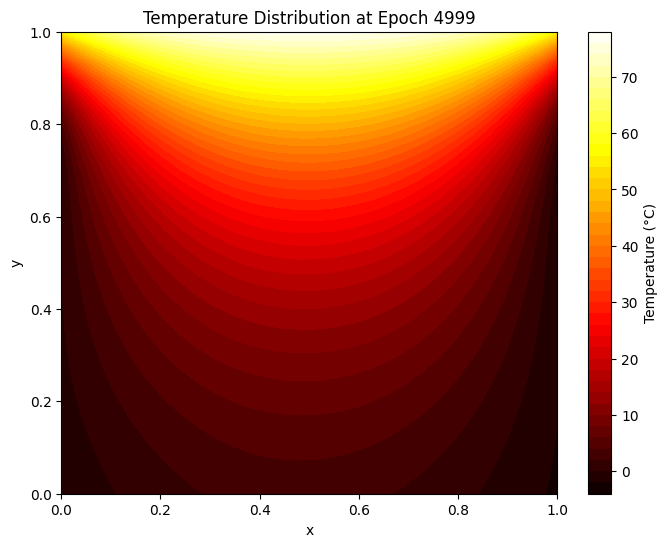

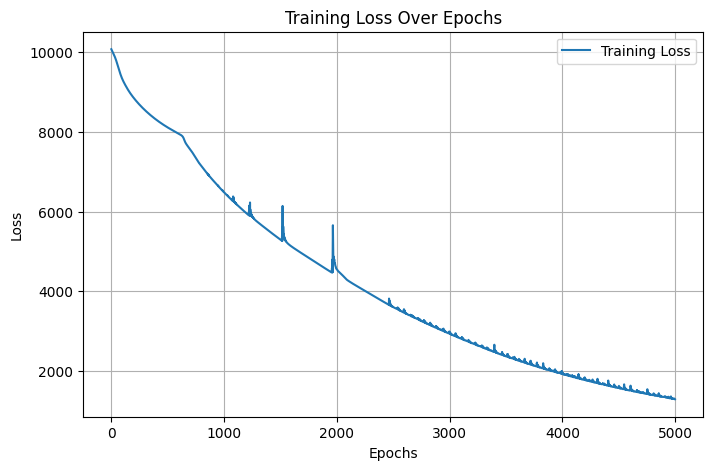

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Neural Network Definition
class FFN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(FFN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

# Generate Domain and Boundary Points
def generate_points(Nx, Ny, Lx, Ly):
    # Interior points
    x = np.linspace(0, Lx, Nx)
    y = np.linspace(0, Ly, Ny)
    X, Y = np.meshgrid(x, y)
    x_col = torch.tensor(X.flatten(), dtype=torch.float32).unsqueeze(1)
    y_col = torch.tensor(Y.flatten(), dtype=torch.float32).unsqueeze(1)

    # Boundary points
    x_left = torch.zeros(Ny, 1)
    y_left = torch.linspace(0, Ly, Ny).unsqueeze(1)

    x_right = Lx * torch.ones(Ny, 1)
    y_right = torch.linspace(0, Ly, Ny).unsqueeze(1)

    x_bottom = torch.linspace(0, Lx, Nx).unsqueeze(1)
    y_bottom = torch.zeros(Nx, 1)

    x_top = torch.linspace(0, Lx, Nx).unsqueeze(1)
    y_top = Ly * torch.ones(Nx, 1)

    boundaries = [
        (x_left, y_left, 0),     # Left boundary (0°C)
        (x_right, y_right, 0),   # Right boundary (0°C)
        (x_bottom, y_bottom, 0), # Bottom boundary (0°C)
        (x_top, y_top, 100)      # Top boundary (100°C)
    ]

    return (x_col, y_col), boundaries

# PDE Residual Loss
def pde_residual_loss(model, x, y):
    x.requires_grad = True
    y.requires_grad = True

    T = model(torch.cat([x, y], dim=1))  # Neural network prediction T(x, y)

    # First derivatives
    grad_T = torch.autograd.grad(T, [x, y], grad_outputs=torch.ones_like(T), create_graph=True)
    T_x, T_y = grad_T[0], grad_T[1]  # dT/dx, dT/dy

    # Second derivatives
    T_xx = torch.autograd.grad(T_x, x, grad_outputs=torch.ones_like(T_x), create_graph=True)[0]
    T_yy = torch.autograd.grad(T_y, y, grad_outputs=torch.ones_like(T_y), create_graph=True)[0]

    # Residual of Laplace's equation
    residual = T_xx + T_yy  # ∂²T/∂x² + ∂²T/∂y²

    loss_residual = torch.mean(residual**2)
    return loss_residual

# Boundary Loss
def boundary_loss(model, x_boundary, y_boundary, T_exact):
    T_pred = model(torch.cat([x_boundary, y_boundary], dim=1))
    loss_boundary = torch.mean((T_pred - T_exact)**2)
    return loss_boundary

# Total Loss Function
def total_loss(model, collocation_points, boundaries):
    # PDE Residual Loss
    x_col, y_col = collocation_points
    loss_pde = pde_residual_loss(model, x_col, y_col)

    # Boundary Losses
    loss_boundary = 0
    for boundary in boundaries:
        x_b, y_b, T_exact_val = boundary
        T_exact = T_exact_val * torch.ones_like(x_b)
        loss_boundary += boundary_loss(model, x_b, y_b, T_exact)

    # Combine losses
    total_loss = loss_pde + loss_boundary
    return total_loss

# Plot Temperature Profile
def plot_temperature(model, X, Y, epoch, Nx, Ny):
    x_flat = X.reshape(-1, 1)
    y_flat = Y.reshape(-1, 1)

    with torch.no_grad():
        T_pred = model(torch.cat([x_flat, y_flat], dim=1)).reshape(Nx, Ny)

    plt.figure(figsize=(8, 6))
    plt.contourf(X.numpy(), Y.numpy(), T_pred.numpy(), cmap='hot', levels=50)
    plt.colorbar(label='Temperature (°C)')
    plt.title(f'Temperature Distribution at Epoch {epoch}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

# Main Function
def main():
    # Parameters
    Lx, Ly = 1.0, 1.0   # Domain dimensions
    Nx, Ny = 30, 30     # Number of points in x and y directions
    hidden_dim = 20     # Hidden layer size
    epochs = 5000       # Number of training epochs
    lr = 1e-3           # Learning rate

    # Generate points
    collocation_points, boundaries = generate_points(Nx, Ny, Lx, Ly)

    # Model and Optimizer
    model = FFN(input_dim=2, output_dim=1, hidden_dim=hidden_dim)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training Loop
    losses = []
    x = torch.linspace(0, Lx, Nx)
    y = torch.linspace(0, Ly, Ny)
    X, Y = torch.meshgrid(x, y)

    for epoch in range(epochs):
        optimizer.zero_grad()

        # Compute total loss
        loss = total_loss(model, collocation_points, boundaries)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Track progress
        losses.append(loss.item())
        if epoch % 500 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
            plot_temperature(model, X, Y, epoch, Nx, Ny)

    # Final Loss Plot
    plt.figure(figsize=(8, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

if __name__ == "__main__":
    main()
